![](https://i.imgur.com/eBRPvWB.png)

# Generowanie poezji za pomocą RNN i PyTorch w oparciu o sylaby.

[W tutorialu](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) użyliśmy RNN, aby sklasyfikować tekst po jednym znaku na raz. Tym razem wygenerujemy tekst po jedej sylabie na raz.
```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title — "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more.

Zobacz [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) żeby nauczyć się więcej w tym temacie.

## Warto przeczytać

Zakładam, że zainstalowałeś przynajmniej PyTorch, znasz Pythona i rozumiesz Tensory:

* http://pytorch.org/ Instrukcje instalacji
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) jak zacząć z PyTorch (ogólnie)
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) dla szczegółowego przeglądu
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeśli byłeś użytkownikiem Lua Torch

Przydałoby się również wiedzieć o RNN'ach i ich działaniu:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) pokazuje kilka przykładów z życia
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) dotyczy LSTM'ów, ale też podaje ogólne informacje na temat RNN

Zobacz także podobne tutoriale z serii:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) używa RNN do klasyfikacji
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) opierając się na tym modelu, dodaje kategorię jako dane wejściowe

## Przygotowanie danych

Plik wejściowy to duży plik tekstowy. Dzielimy go na sylaby.

### Podzielenie korpusu na sylaby

In [0]:
from pathlib import Path
dataset_path = Path('data/rnn_generator'); dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [2]:
ls -lah $dataset_path/

total 232K
drwxr-xr-x 3 root root 4.0K Jul  2 08:30 ./
drwxr-xr-x 3 root root 4.0K Jul  2 08:30 ../
-rw-r--r-- 1 root root 219K Jul  2 08:30 pan_tadeusz.txt
drwxr-xr-x 2 root root 4.0K Jul  2 08:30 tmp/


In [0]:
fn_corpus_char = dataset_path/'pan_tadeusz.txt'
fn_corpus_caps = dataset_path/'pan_tadeusz.caps1.txt'
fn_corpus_syl = dataset_path/'pan_tadeusz.syl1.txt'

In [0]:
import re, string

def _do_caps(ss):
  TOK_UP,TOK_CAP = ' _up_ ', ' _cap_ '
  res = []
  re_word = re.compile('\w')
  for s in re.findall(r'\w+|\W+', ss):
      res += ([TOK_UP,s.lower()] if (s.isupper() and (len(s)>2))
              else [TOK_CAP,s.lower()] if s.istitle()
              else [s.lower()])
  return ''.join(res)

In [5]:
corpus_tmp = fn_corpus_char.open('r').read()
corpus_tmp = _do_caps(corpus_tmp)
fn_corpus_caps.open('w').write(corpus_tmp)

246668

In [0]:
platform_suffixes = {'Linux': 'linux', 'Darwin': 'macos'}
import platform
platform_suffix = platform_suffixes[platform.system()]
stemmer_bin = f'LD_PRELOAD="" bin/stemmer.{platform_suffix}'

In [0]:
# !$stemmer_bin -h

In [8]:
!$stemmer_bin -s 7683 -v -d bin/stemmer2.dic -i $fn_corpus_caps -o $fn_corpus_syl

Stemmer 2.0.3 2018-04-19 (Linux i386)
For Korrida database, spellchecker and hyphenator copyright (C) 1993-2018 Wojciech Czarnowski
For Stemmer copyright (C) 2018 Krzysztof Wolk and Wojciech Czarnowski
Wojciech Czarnowski: wojtek.czarnowski@gmail.com, +48(608)202-272
Krzysztof Wolk: krz.wolk@gmail.com, +48(606)918-623

Dictionary: "bin/stemmer2.dic"
Input file: "data/rnn_generator/pan_tadeusz.caps1.txt"
Output file: "data/rnn_generator/pan_tadeusz.syl1.txt"
Stem number: "7683"

Stemming options:
  StemNiePrefix     : Yes
  StemExtraPrefixes : Yes
  StemPrefixesInRoot: No

Syllable division options:
  DivideWords          : Yes
  DivideWithDictionary : Yes
  DivideAlgorithmically: Yes
  DivideUknkownWords   : Yes
  divideAfterChar      : 1

Stemming formatting options:
  StemInSuffix       : No
  ShowPOSInfo        : No
  ShowExtraPOSInfo   : No

  ShowGroupCode      : No
  ShowBaseSuffixCodes: No
  ShowSuffixCode     : No

  stemDelimiterStr   : "++ --"
  codeDelimiterStr   : "@@"

Ste

### Załadowanie danych

Ładujemy plik do pamięci i tokenizujemy. Tworzymy też listę wszystkich tokenów `all_tokens`.

In [9]:
import string
import random
import re

file = open(fn_corpus_syl).read()
file_len = len(file)
print('file_len =', file_len)

file_len = 398396


In [10]:
# taken from fastai/text.py
import re, string

# remove +,- chars from punctuation set to keep syllables e.g.'--PO++' intact
# remove _ char to keep tokens intact
punctuation=re.sub('[_\+-]', '', string.punctuation)
re_tok = re.compile(f'([{punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s, repl_unk=True): 
  strings = re_tok.sub(r' \1 ', s).replace('\n', ' _eol_ ').split()
  if repl_unk:
    strings = [str2tok(s) for s in strings]
  return strings

file_tok = tokenize(file, repl_unk=False); len(file_tok), file_tok[:8]
file_tok_len = len(file_tok)

spec_tokens = ['_unk_', '_eol_', '_cap_', '_up_']

all_tokens = []
all_tokens.extend(spec_tokens)
all_tokens.extend(sorted(list(set(file_tok))))
n_tokens = len(all_tokens); print(n_tokens, all_tokens[:50])

tok2idx_dict = {tok: idx for (idx, tok) in enumerate(all_tokens)}

def str2tok(str) -> int:
  return str if tok2idx_dict.get(str, 0) else all_tokens[0]

def tok2idx(tok) -> int:
  return tok2idx_dict.get(tok, 0)

5059 ['_unk_', '_eol_', '_cap_', '_up_', '!', '"', '%', "'", '(', ')', ',', '--', '--a++', '--aczéj', '--ał', '--b++', '--ba', '--ba++', '--bach', '--baj++', '--bak', '--ban', '--ban++', '--bar++', '--barz', '--baw', '--baw++', '--bał', '--baż', '--bcem', '--be++', '--bek', '--bel', '--bel++', '--belg', '--bem', '--ber++', '--bez++', '--beł', '--bi', '--bi++', '--bia', '--bia++', '--biad', '--biar++', '--biać', '--biał', '--bic', '--bie', '--bie++']


In [0]:
def str2syl2tok(text):  
  fn_tmp_text_caps = Path(tmp_path / 'tmp_text_caps1.txt')
  fn_tmp_text_syl = Path(tmp_path / 'tmp_text_syl1.txt')
  
  text = _do_caps(text)
  fn_tmp_text_caps.open('w').write(text)
  
  !$stemmer_bin -s 7683 -d bin/stemmer2.dic -i $fn_tmp_text_caps -o $fn_tmp_text_syl
  
  text_syl = fn_tmp_text_syl.open('r').read()
  text_tok = tokenize(text_syl, repl_unk=True)
  return text_tok

In [12]:
tekst = 'LITWO! Ojczyzno moja!\nTy jesteś jak zdrowie.\nIle cię trzeba cenić ble ble '
tekst_tok = str2syl2tok(tekst)
print(tekst_tok)

['_up_', 'lit++', '--wo', '!', '_cap_', 'oj++', '--czyz++', '--no', 'mo++', '--ja', '!', '_eol_', '_cap_', 'ty', 'je++', '--s++', '--teś', 'jak', 'zdro++', '--wie', '.', '_eol_', '_cap_', 'ile', 'cię', 'trze++', '--ba', 'ce++', '--nić', '_unk_', '_unk_', '_eol_']


Aby stworzyć 'wejścia' z tego dużego ciągu danych, podzielimy go na kawałki.

In [0]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_tok_len - chunk_len -1)
    end_index = start_index + chunk_len + 1
    return file_tok[start_index:end_index]

In [14]:
#FIXME: decode tokens _eol_, _unk_, _cap_, _up_
def syl2str(a_list, delim='/'): return ' '.join(a_list).replace('++ --', delim)
print(syl2str(random_chunk()))

_cap_ ro/sprze/strze/nił sze/ro/ko prze/d/nie krzy/żem ła/py , _eol_ _cap_ dy/szał je/sz/cze , wy/le/wał stru/mień krwi przez chra/py , _eol_ _cap_ ot/wie/rał je/sz/cze o/czy , lecz gło/wy nie ru/szy ; _eol_ _cap_ pi/jaw/ki _cap_ pod/ko/mo/rze/go dzier/żą go pod u/szy , _eol_ _cap_ z lewéj stro/ny _cap_ strap/czy/na , a s prawéj za/wi/sał _eol_ _cap_ spra/wnik i du/sząc gar/dziel krew czar/ną wy/sy/sał . _eol_ _eol_ _cap_ za/czem _cap_ woj/ski ros/ka/zał kij że/laz/ny wło/żyć _eol_ _cap_ psom mię/dzy zę/by , i tak pa/sz/czę/ki ro/stwo/rzyć . _eol_ _cap_ kol/ba/mi prze/wró/co/no na wznak zwie/rza zwło/ki , _eol_ _cap_ i znów trzy/kro/t/ny wi/wat u/de/rzył w ob/ło/ki . _eol_ _eol_ -- _cap_ a co ? krzyk/nął _cap_ as/sses/sor , krę/cąc strzel/by ru/rą , _eol_ _cap_ a co ? fu/zyj/ka mo/ja ? gó/rą no/si gó/rą ! _eol_ _cap_ a co ? fu/zyj/ka mo/ja ? nie wiel/ka pta/szy/na , _eol_ _cap_ a jak się po/pi/sa/ła ? to jéj nie no/wi/na , _eol_ _cap_ nie pu/ści ona na wiatr ża/dne/go ła/dun/ku , _eol_

## GPU

In [15]:
import torch

USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=True


## Budowanie modelu

Ten model przyjmie jako wejściie token dla kroku $ t _ {- 1} $ i ma wyprowadzić następny token $ t $. Istnieją trzy warstwy - jedna warstwa liniowa, która koduje znak wejściowy do stanu wewnętrznego, jedna warstwa GRU (która może sama mieć wiele warstw), która działa na tym stanie wewnętrznym i stanie ukrytym, oraz warstwa dekodera, która wyprowadza rozkład prawdopodobieństwa.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

## Tensory wejściowe i docelowe

Każdy 'kawałek' zostanie przekształcony w tensor, a dokładnie w `LongTensor` (używany do wartości całkowitych), poprzez przepuszczenie wszystkich tokenów ciągu i wyszukiwanie indeksu każdej sylaby w `all_tokens`.

In [0]:
# Turn token list into list of longs
def tok_tensor(token_list):
    tensor = torch.zeros(len(token_list)).long()
    for c in range(len(token_list)):
        tensor[c] = tok2idx(token_list[c])
    
    return Variable(to_gpu(tensor))

In [18]:
#FIXME: nie dekodować _eol_ na końcu stringa
tekst = 'Litwo! Ojczyzno moja! ty jesteś jak zdrowie;'
tekst_tok = str2syl2tok(tekst)
print(tekst_tok)
# a_token_list = tekst_tok; print(a_token_list)
print(tok_tensor(tekst_tok))

['_cap_', 'lit++', '--wo', '!', '_cap_', 'oj++', '--czyz++', '--no', 'mo++', '--ja', '!', 'ty', 'je++', '--s++', '--teś', 'jak', 'zdro++', '--wie', ';', '_eol_']
tensor([ 2721,  3565,  2396,     4,  2721,  3776,   435,  1424,  3642,
          865,     4,  4468,  3365,  1738,  2151,  3354,  4810,  2332,
         2716,  2722], device='cuda:0')


Wreszcie możemy zmontować parę tensorów wejściowych i docelowych do treningu, z losowego kawałka. Wejściem zostaną wszystkie tokeny * aż do przedostatniego*, a celem (targetem) będą wszystkie tokeny * od drugiego*. Jeśli więc nasz kawałek to "abc", wejście będzie odpowiadać "ab", podczas gdy cel to "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = tok_tensor(chunk[:-1])
    target = tok_tensor(chunk[1:])
    return inp, target

## Ewaluacja

Aby ocenić sieć, będziemy podawać po jednym tokenie na raz, wykorzystywać wyjścia sieci jako rozkład prawdopodobieństwa dla następnego znaku i powtarzać. Aby rozpocząć generowanie, przekazujemy ciąg wstępny, aby rozpocząć budowanie stanu ukrytego, z którego następnie generujemy po jednym tokenie na raz.

In [0]:
def evaluate(prime_tokl=[all_tokens[1]], predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = tok_tensor(prime_tokl)
    predicted = list(prime_tokl)  # need a copy of the list

    # Use priming token list to "build up" hidden state
    for p in range(len(prime_tokl) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        
        # in pytorch 0.4.0 max, min fail if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/6996
        # in all pytorch versions multinomial fails if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/871
        # temp fix, kill Infs and nans
        # https://discuss.pytorch.org/t/how-to-set-inf-in-tensor-variable-to-0/10235
        output_dist[output_dist == float("Inf")] = 0
        output_dist[output_dist == float("nan")] = 0
        
        top_i = torch.multinomial(output_dist, 1)[0].item()
        
        # Add predicted token to the list and use as next input
        predicted_token = all_tokens[top_i]
        predicted.append(predicted_token)
        inp = tok_tensor([predicted_token])

    return predicted

## Trenowanie modelu

Funkcja pomocnicza do wydrukowania upływającego czasu:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Główna funkcja treningowa

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].expand(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Opcjonalny monitoring postępu treningu

In [0]:
USE_VISDOM = False

import numpy as np

vis = None
if USE_VISDOM:
    import visdom
    vis = visdom.Visdom(port=8890)

def vis_update_line_chart(vis, name, x, y, first_step):
    if not USE_VISDOM: return
    vis.line(Y=np.array([y]), X=np.array([x]), win=name, opts=dict(title=name),
             update=None if first_step else 'append')

def vis_update_text_win(vis, name, text):
    if not USE_VISDOM: return
    vis.text(text, win=name, opts=dict(title=name), append=False)

In [0]:
class X(str):
    def rpl(self, p, c='lightgray'):
        return X(self.replace(p, f'<font color="{c}">{p}</font>'))

In [0]:
def bad_words(e_syl): e_str = syl2str(e_syl); return (e_str.count('++') + e_str.count('--')) / len(e_syl)

Następnie definiujemy parametry treningowe i rozpoczynamy trening:

In [26]:
n_epochs = 3000   # 2000
print_every = 100
plot_every = 50
hidden_size = 500 # 100
n_layers = 3 # 1
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

start = time.time()
all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

from tqdm import tqdm

iterable = range(1, n_epochs + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True)
first_step = True



RNN(
  (encoder): Embedding(5059, 500)
  (gru): GRU(500, 500, num_layers=3)
  (decoder): Linear(in_features=500, out_features=5059, bias=True)
)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [27]:
for epoch in tqdm_:
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', epoch, loss, epoch == 1)
    
    # progress_bar
    tqdm_.set_postfix({'loss': loss})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    # bad words
    # TODO: use 'Litwo! Ojczyzno moja!'
    prime_str = file_tok[13:18]
    bw = bad_words(evaluate(prime_str, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', epoch, bw, epoch == 1)
    
    if epoch % print_every == 0:
        e_syl = evaluate(prime_str, 100)
        e_str = syl2str(e_syl)
        stats_str = '\n[%s (%d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, bw)
        print(stats_str)
        e_html = X(e_str).rpl('/').rpl('--', c='red').rpl('++', c='red')
        print(e_str, '\n', flush=True)
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)

    if epoch % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', epoch, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', epoch, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

  3%|▎         | 99/3000 [04:07<2:00:43,  2.50s/it, loss=6]  


 7s (100 3%) loss=5.9974 bw=0.2952]
go/s/po/dar/stwo _eol_ _cap_ a --łość --li do tu --szam --kiem , s ci/wis/go z że je/dziei , _eol_ _cap_ pio/ła w kur/rza --dę --jeż++ pod , w --dział --bi --go dom --deu/ry , _eol_ _cap_ s a przy księ/rze --czy++ dzi/ki pa++ dwo++ , po/wy/gród --ki , _eol_ _cap_ i --czą/cie/lej --ty --sta/nę++ go/łej , na++ ten , _eol_ _cap_ w spraw kla/ni/go kró/niu ob++ a u++ męż/ki , _eol_ _cap_ lewéj char++ bia/lą chcia/we --szy wo++ ich --ko nie , 



  4%|▍         | 135/3000 [05:33<1:58:00,  2.47s/it, loss=5.5]

KeyboardInterrupt: ignored

## Rysowanie wykresu funkcji straty

Wykreślanie historycznej straty z all_losses pokazuje uczenie sieci:

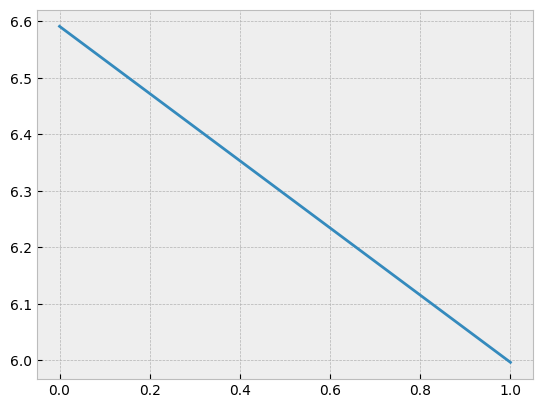

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('bmh')

plt.figure()
plt.plot(all_losses)

## Zapisanie modelu

In [0]:
ALLTOKS, MODEL = ['all_tokens', 'model']

fn_pan_tadeusz = {ALLTOKS: 'all_tokens.pan_tadeusz.p', MODEL: 'pan_tadeusz.h300.l2.e3000.gpu.torch'}

fn_dict = fn_pan_tadeusz

In [0]:
# save all_tokens
import pickle

pickle.dump(all_tokens, open(tmp_path / fn_dict[ALLTOKS], 'wb'))

In [0]:
# all_tokens = pickle.load( open( tmp_path / fn_dict[ALLTOKS], 'rb' ) )
# n_characters = len(all_tokens)

In [0]:
decoder.state_dict

In [0]:
import warnings
warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

In [0]:
 # decoder = torch.load(model_path)

In [0]:
model_path

In [0]:
ls -lah $tmp_path

## Ewaluacja w różnych "temperaturach"

W powyższej funkcji `evaluate`, za każdym razem, gdy dokonywana jest prognoza, wyjścia są dzielone przez przekazany argument "temperature". Użycie większej liczby sprawia, że wszystkie akcje są bardziej jednakowo prawdopodobne, a tym samym dają nam "bardziej losowe" wyniki. Użycie mniejszej wartości (mniejszej niż 1) sprawia, że wysokie prawdopodobieństwa przyczyniają się bardziej. Gdy ustawiamy temperaturę na zero, wybieramy tylko najbardziej prawdopodobne wyjścia.

Możemy zobaczyć te efekty poprzez dostosowanie argumentu `temperature`.


In [0]:
# TODO: use 'Litwo! Ojczyzno moja!'
prime_tokl = file_tok[13:18]
print(syl2str(evaluate(prime_tokl, 200, temperature=0.8), delim='/'))

Niższe temperatury daja mniejszą różnorodność, wybierając tylko bardziej prawdopodobne wyjścia:

In [0]:
print(syl2str(evaluate(prime_tokl, 200, temperature=0.2), delim='/'))

Wyższe temperatury są bardziej różnorodne, wybierając mniej prawdopodobne wyjścia:

In [0]:
print(syl2str(evaluate(prime_tokl, 200, temperature=1.4), delim='/'))

## Monitorowanie maszyny wirtualnej

In [0]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [30]:
print_memsize()

1.7818 GB


In [31]:
!uptime

 20:46:30 up  2:18,  0 users,  load average: 0.41, 0.72, 0.45


## Ćwiczenia

* Trenuj z własnym zestawem danych, np.
     * Tekst od innego autora
     * Posty na blogu
     * Kody źródłowe
* Zwiększ liczbę warstw i rozmiar sieci, aby uzyskać lepsze wyniki

**Następnie**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)